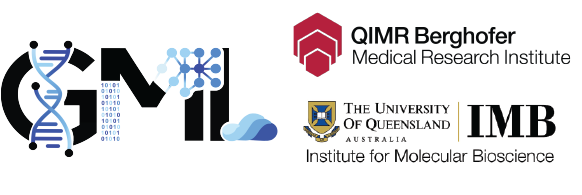 \
**This script has been generated by Onkar Mulay and Levi Hockey from the *Genomics and Machine Learning Lab*:**
* Data used below is currently not published or publically available. For more information about the scripts or for the use of this datasets beyond this tutorial please contact o.mulay@uq.edu.au or l.hockey@uq.edu.au
* Code and *conda* environments used are available from https://github.com/GMLTestLab/gml-teaching

## Table of Contents

| Section   | Description             |
|-----------|-------------------------|
| [stLearn](#stLearn)   | In-house cell-cell interaction algorithm for cell-cell interaction of spatial dataset.     |
| [MMCCI](#MMCCI)           | Integration of Cell-Cell Interaction Results.      |
| [ADVANCED](#ADVANCED)           | Advanced material for CCI and other interesting packages.      |

###### Users should only run Inference of CCI and MMCCI; as cell-cell interactions is time consuming step, we have already run CCI and saved the results.

##### Legend
<font color="black"> &#9899; Explaination of the concept. \
<font color="blue"> &#128309; Explaination/summary of the code block. \
<font color="red"> &#128308; Anything after the text in red needs to be run; else avoid running the cell. \
<font color="purple"> &#128995; Questions. \
<font color="green"> &#128994; Hints for the quesitons.

# stLearn

stLearn is a python package to perform cell-cell interactions of spatial datasets like Visium, Xenium etc. stLearn has two test categories:- 
1. For testing neighbourhoods with significant enrichment of LR co-expression (neighbourhood LR analysis - to find spatial locations and significant LR pairs used for interactions). 
2. For finding cell type combinations with significantly greater interactions than other cell types across the tissue (cell type-specific CCI analysis).

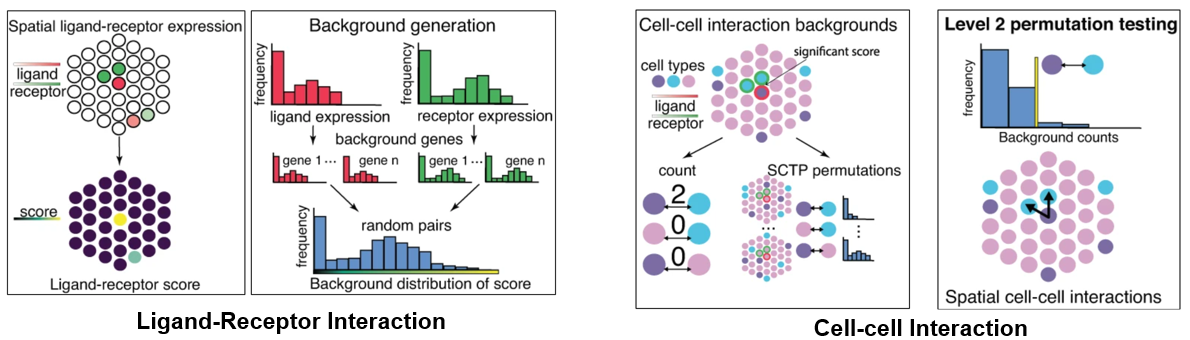

#### Code

<font color="blue"> In this cell we load the Raw spatial dataset and filter out bad genes; the genes that are not present in more than 3 cells. We normalise the data using CPM normalisation per spot/cell.

In [ ]:
## Load libraries
import stlearn as st
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scanpy as sc


data_dir = "/data/module2/data/"

# Reading the RAW data
visium = st.Read10X(
    path=f"{data_dir}/Visium_Skin_A2/outs/"
    )
visium.var_names_make_unique()

# Filter bad spots and normalise
st.pp.filter_genes(visium, min_cells=3)
st.pp.normalize_total(visium) 

<font color="blue"> In this cell we load the deconvolution results from CARD and add it to the anndata for Cell-Cell Interaction pipeline.

In [ ]:
# Load the deconvolution results and visualise the format of the dataframe
card_path = f"{data_dir}/visium_decon.csv"
spot_mixtures = pd.read_csv(card_path, index_col=0)
spot_mixtures.head()

# Add the deconvolution results to 
spot_mixtures['predicted_cell_type'] = spot_mixtures.idxmax(axis=1) # Get the cell type with the highest proportion
labels = spot_mixtures.loc[:,'predicted_cell_type'].values.astype(str) # Get the cell type labels
spot_mixtures = spot_mixtures.drop(['predicted_cell_type'], axis=1) # Drop the predicted cell type column

# Subset the visium to only include spots in the spot mixtures
visium = visium[spot_mixtures.index.values]

print('Spot mixture order correct?: ',
    np.all(spot_mixtures.index.values==visium.obs_names.values)) # Check is in correct order

# NOTE: using the same key in data.obs & data.uns
visium.obs['cell_type'] = labels # Adding the dominant cell type labels per spot
visium.obs['cell_type'] = visium.obs['cell_type'].astype('category')
visium.uns['cell_type'] = spot_mixtures # Adding the cell type scores

# Plot the cell-type labels on tissue
st.pl.cluster_plot(visium, use_label='cell_type')

#### LR scoring and significance testing `st.tl.cci.run`

<font color="blue"> We load the LR Database. Then we first compute the LR interaction scores, and later calculate the spots that are significantly interacting using a background test correction. Calculation of LR interaction scores within a spot/cell or between neighboruing spots/cells is given by:- </font>

#### Interactions within-spots/cells 
$$
{LR}_{score}=\frac{{Expr}_{L,S}\times \left[Exp{r}_{R,S} > 0\right]+Exp{r}_{R,S| N}\times \left[Exp{r}_{L,S} > 0\right]}{2}
$$

#### Interactions between-spots/cells 
$$
{LR}_{score}=	\frac{1}{2}\left(mean\big(Exp{r}_{L,S| N}\times \left[Exp{r}_{R,S} \, > \, 0\right]\big)\right.\\ 	+mean\big(Exp{r}_{R,S| N}\times \left[Exp{r}_{L,S} \, > \, 0\right]\big)
$$

LR significance testing is a robust statistical method to test LR interactions, avoiding biases toward abundant LR pairs and random co-expression of non-interacting gene pairs across neighboring spots/cells. A random background of LR scores for non-interacting genes is established using genes not in the LR database but within the same expression ranges as each ligand and receptor gene in the LR pair being tested. These random genes, representing ligand and receptor expression, are randomly paired to generate non-interacting gene-gene pairs with equivalent expression levels to the LR pair. The LRscore is then calculated for each random pair to create the background distribution per spot and LR pair. A p-value is calculated for each spot and LR pair as the proportion of background scores across k random pairs that had a score greater than the LRscore, using Benjamini/Hochberg correction for multiple testing.

In [ ]:
# Loading the LR databases available within stlearn (from NATMI)
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='human')
print(len(lrs))


# Running the analysis #
st.tl.cci.run(visium, lrs,
                min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                distance=None, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                n_pairs=1000, # Number of random pairs to generate; low as example, recommend ~10,000
                n_cpus=4, # Number of CPUs for parallel. If None, detects & use all available.
                )

lr_info = visium.uns['lr_summary'] # A dataframe detailing the LR pairs ranked by number of significant spots.
print('\n', lr_info)

st.tl.cci.adj_pvals(visium, correct_axis='spot',
                pval_adj_cutoff=0.05, adj_method='fdr_bh')

# Showing the rankings of the LR from a global and local perspective.
# Ranking based on number of significant hotspots.
st.pl.lr_summary(visium, n_top=500)
st.pl.lr_summary(visium, n_top=50, figsize=(10,3))
st.pl.lr_diagnostics(visium, figsize=(10,2.5))
st.pl.lr_n_spots(visium, n_top=50, figsize=(11, 3),
                    max_text=100)
st.pl.lr_n_spots(visium, n_top=500, figsize=(11, 3),
                    max_text=100)


best_lr = visium.uns['lr_summary'].index.values[0] # Just choosing one of the top from lr_summary

stats = ['lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)']
fig, axes = plt.subplots(ncols=len(stats), figsize=(16,6))
for i, stat in enumerate(stats):
    st.pl.lr_result_plot(visium, use_result=stat, use_lr=best_lr, show_color_bar=False, ax=axes[i])
    axes[i].set_title(f'{best_lr} {stat}')
    
fig, axes = plt.subplots(ncols=2, figsize=(8,6))
st.pl.lr_result_plot(visium, use_result='-log10(p_adjs)', use_lr=best_lr, show_color_bar=False, ax=axes[0])
st.pl.lr_result_plot(visium, use_result='lr_sig_scores', use_lr=best_lr, show_color_bar=False, ax=axes[1])
axes[0].set_title(f'{best_lr} -log10(p_adjs)')
axes[1].set_title(f'{best_lr} lr_sig_scores')

st.pl.lr_plot(visium, best_lr, inner_size_prop=0.1, outer_mode='binary', pt_scale=5,
            use_label=None, show_image=True,
            sig_spots=False)

st.pl.lr_plot(visium, best_lr, outer_size_prop=1, outer_mode='binary', pt_scale=20,
            use_label=None, show_image=True,
            sig_spots=True)

#### Cell type-specific interaction analysis - `st.tl.cci.run_cci`

This test is to check if a pair of cell types interact using a given pair of LR. This test accounts for the fact that more than one cell type may be present at a given spot. The cell type interaction analysis uses the significant spot/bin/cell outputs from the spot LR analysis above. For each LR pair and spot, the count matrix CCILR of shape nc × nc is calculated, where nc is the number of all predicted cell types. Each row in CCILR corresponds to the signal emitting cell types (ligand expressing; sender), and each column to the signal detecting cell types (receptor expressing; receiver).

<font color="blue"> We run cci code and save the data for plotting

In [ ]:
# Running the counting of co-occurence of cell types and LR expression hotspots #
st.tl.cci.run_cci(visium, 'cell_type', # Spot cell information either in data.obs or data.uns
                min_spots=3, # Minimum number of spots for LR to be tested.
                spot_mixtures=True, # If True will use the label transfer scores,
                                    # so spots can have multiple cell types if score>cell_prop_cutoff
                cell_prop_cutoff=0.2, # Spot considered to have cell type if score>0.2
                sig_spots=True, # Only consider neighbourhoods of spots which had significant LR scores.
                n_perms=100, # Permutations of cell information to get background, recommend ~1000,
                n_cpus=4 # Number of CPUs for parallel. If None, detects & use all available.
                )

st.pl.cci_check(visium, 'cell_type')
# visium.write_h5ad(f"{data_dir}/visium_stlearn.h5ad")

In [ ]:
# visium = sc.read_h5ad(f"{data_dir}/finalised_files_to_move/visium_stlearn.h5ad")

<font color="blue"> Visualisation of a sample LR pair 

In [ ]:
best_lr = visium.uns['lr_summary'].index.values[0]
stats = ['lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)']
fig, axes = plt.subplots(ncols=len(stats), figsize=(16,6))
for i, stat in enumerate(stats):
    st.pl.lr_result_plot(visium, use_result=stat, use_lr=best_lr, 
                         show_color_bar=False, ax=axes[i])
    axes[i].set_title(f'{best_lr} {stat}')
plt.show()

<font color="blue"> Plot the cell-type labels

In [ ]:
sc.pl.spatial(visium, color="cell_type")
plt.show()

<font color="blue"> Check interaction and cell type frequency correlation

In [ ]:
st.pl.cci_check(visium, 'cell_type')
plt.show()

<font color="blue"> Chord plot of all interactions in a sample 

In [ ]:
st.pl.lr_chord_plot(visium, 'cell_type')
plt.show()

<font color="blue"> Chord plot of all interactions for a specific LR pair

In [ ]:
st.pl.lr_chord_plot(visium, 'cell_type', best_lr)
plt.show()

### <font color="purple"> Questions: </font>

<font color="purple">
    
1. Which LR pairs are significantly interacting?
2. Which cell-types are interacting for a given LR pair?
    
<font color="green"> **Hint:** stLearn uses a different structure compared to CellChat. \
Explore the different slots in stLearn anndata object. (Check -> visium.uns["per_lr_cci_cell_type"])

# MMCCI
***M***ulti***m***odal ***C***ell-***C***ell Interaction ***I***ntegration 

https://github.com/GenomicsMachineLearning/MMCCI

MMCCI is a Python package developed internally by Levi and Onkar to integrate the cell-cell interaction results across multiple samples and multiple modalities. It also offers various downstream analyses to infer the changed in cellular and molecular mechanisms due to altered cellular interactions in diseases.

For a deeper look at MMCCI and what it can do, look at [MMCCI](https://github.com/BiomedicalMachineLearning/MultimodalCCI). For help with running the package on your own data or if you have any questions, reach out to Levi at ``l.hockey@uq.edu.au``.

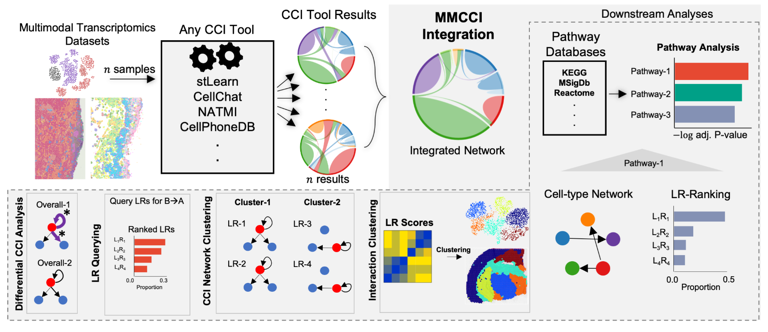

# ADVANCED

#### Other interesting CCI tools

`SpatialDM` https://github.com/StatBiomed/SpatialDM  A statistical model and toolbox to quickly identify the spatial co-expression 

`CellPhoneDB` https://github.com/Teichlab/cellphonedb Cell-type specific LR-interactions 

`NCEM` https://github.com/theislab/ncem Deep Learning based cell-cell interaction algorithm

`MMCCI` https://www.biorxiv.org/content/10.1101/2024.02.28.582639v1.full
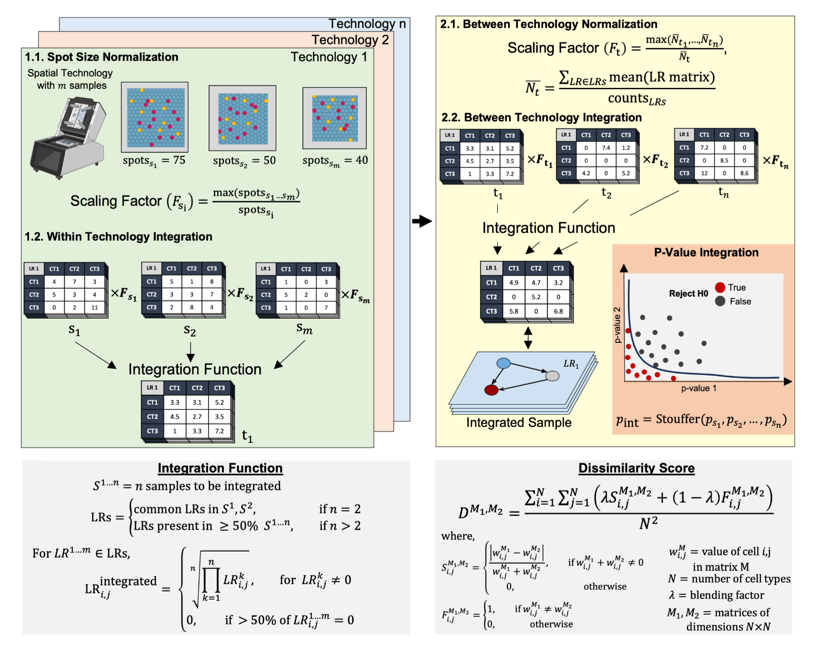